In [ ]:
from google.colab import drive
import os
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/ai final project')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Model loaded successfully!
Loading all frame data...
Loaded 650 frames from M-bIqxvF984_frames.json
Loaded 828 frames from JW22NeQXk64_frames.json
Loaded 906 frames from qegibGSstNE_frames.json
Loaded 337 frames from eiGC3e78JVw_frames.json
Loaded 741 frames from kVYyDO0B6xo_frames.json
Loaded 629 frames from L90h-1Sntnw_frames.json
Total frames loaded: 4091

Generating subtitle embeddings...
Generating embeddings for subtitles...


Batches:   0%|          | 0/128 [00:00<?, ?it/s]

Generated embeddings for 4091 frames

Creating time-based chunks...
Created 407 time-based chunks for video M-bIqxvF984
Created 540 time-based chunks for video JW22NeQXk64
Created 589 time-based chunks for video qegibGSstNE
Created 230 time-based chunks for video eiGC3e78JVw
Created 509 time-based chunks for video kVYyDO0B6xo
Created 431 time-based chunks for video L90h-1Sntnw
Created 2706 total time-based chunks

--- Chunk 0 from video M-bIqxvF984 (2 frames) ---
Start time: 0.08s, End time: 1.83s
Subtitles:
- [0.08s] 
- [1.83s] ear video we have seen statistical


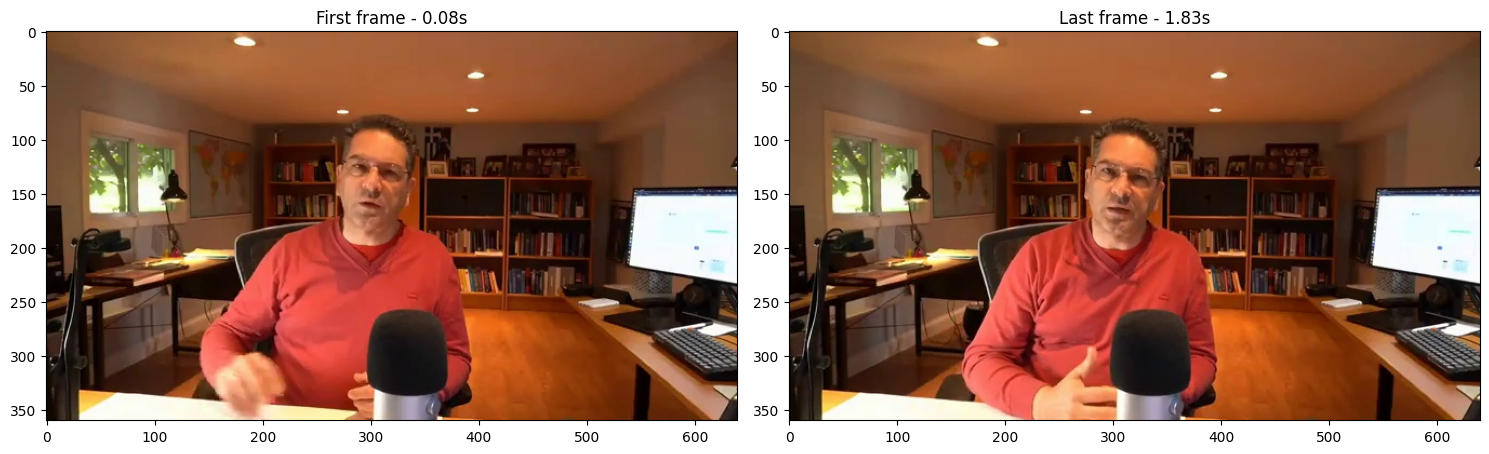

Saved 2706 chunks to data/processed/time_chunks.json

Creating semantic chunks...
Created 501 semantic chunks for video M-bIqxvF984
Created 655 semantic chunks for video JW22NeQXk64
Created 713 semantic chunks for video qegibGSstNE
Created 272 semantic chunks for video eiGC3e78JVw
Created 587 semantic chunks for video kVYyDO0B6xo
Created 487 semantic chunks for video L90h-1Sntnw
Created 3215 total semantic chunks

--- Chunk 0 from video M-bIqxvF984 (1 frames) ---
Start time: 0.08s, End time: 0.08s
Subtitles:
- [0.08s] 


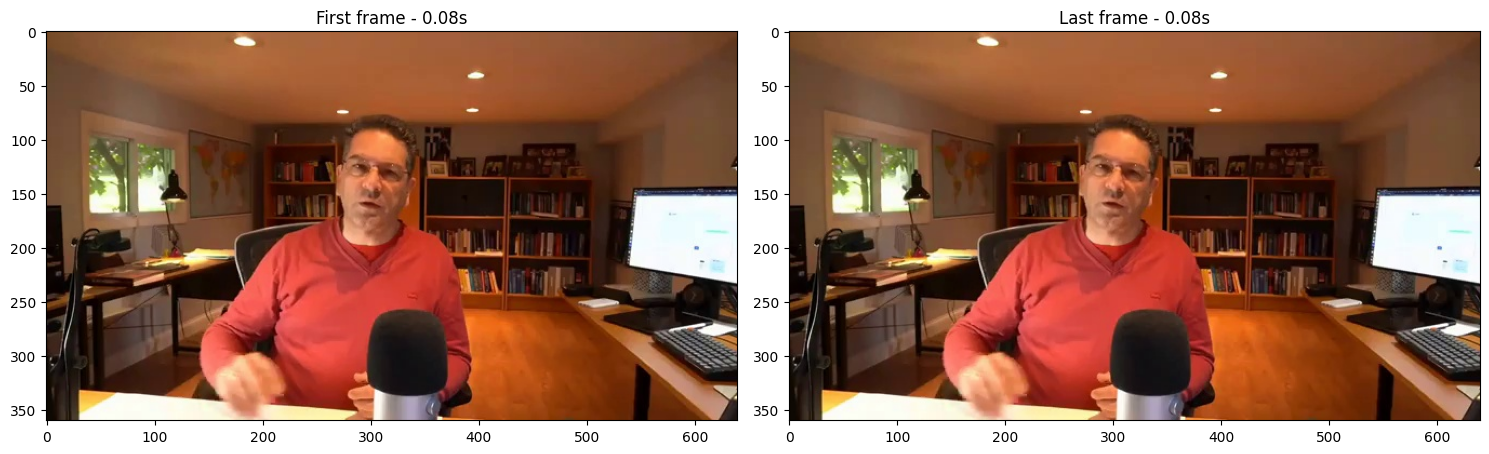

Saved 3215 chunks to data/processed/semantic_chunks.json

Creating hybrid chunks...
Created 510 hybrid chunks for video M-bIqxvF984
Created 655 hybrid chunks for video JW22NeQXk64
Created 711 hybrid chunks for video qegibGSstNE
Created 274 hybrid chunks for video eiGC3e78JVw
Created 613 hybrid chunks for video kVYyDO0B6xo
Created 500 hybrid chunks for video L90h-1Sntnw
Created 3263 total hybrid chunks

--- Chunk 0 from video M-bIqxvF984 (1 frames) ---
Start time: 0.08s, End time: 0.08s
Subtitles:
- [0.08s] 


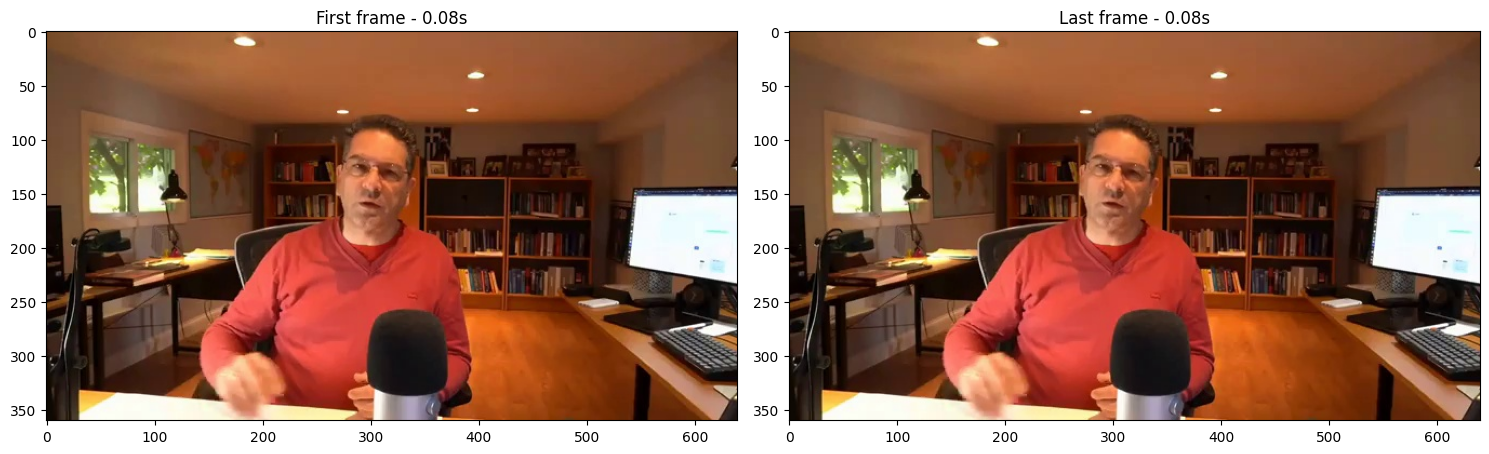

Saved 3263 chunks to data/processed/hybrid_chunks.json

Chunking complete!


In [ ]:
# Import required libraries
import json
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
import torch
from sentence_transformers import SentenceTransformer
import cv2
from IPython.display import display, HTML

# Load SentenceTransformer model for generating embeddings
model = SentenceTransformer('all-MiniLM-L6-v2')
print("Model loaded successfully!")

# Function to load frame data from JSON
def load_frame_data(video_id=None):
    """
    Load frame data from JSON file(s)

    Args:
        video_id: YouTube video ID (if None, load all videos)

    Returns:
        List of dictionaries containing frame information
    """
    processed_dir = "data/processed"
    all_frames = []

    # List all JSON files
    json_files = [f for f in os.listdir(processed_dir) if f.endswith("_frames.json")]

    if video_id:
        # Filter for specific video
        json_files = [f for f in json_files if f.startswith(f"{video_id}_")]

    if not json_files:
        print(f"No frame data files found in {processed_dir}")
        return []

    # Load each JSON file
    for json_file in json_files:
        json_path = os.path.join(processed_dir, json_file)
        with open(json_path, 'r') as f:
            frames = json.load(f)
            all_frames.extend(frames)
            print(f"Loaded {len(frames)} frames from {json_file}")

    print(f"Total frames loaded: {len(all_frames)}")
    return all_frames

# Function to generate embeddings for subtitles
def generate_subtitle_embeddings(frames):
    """
    Generate embeddings for subtitle text in frames

    Args:
        frames: List of frame dictionaries

    Returns:
        Dictionary mapping frame indices to embeddings
    """
    # Extract subtitle texts
    texts = [frame['subtitle_text'] for frame in frames]

    # Generate embeddings
    print("Generating embeddings for subtitles...")
    embeddings = model.encode(texts, show_progress_bar=True)

    # Create mapping from frame index to embedding
    embedding_map = {}
    for i, frame in enumerate(frames):
        key = f"{frame['video_id']}_{frame['frame_index']}"
        embedding_map[key] = embeddings[i]

    print(f"Generated embeddings for {len(embedding_map)} frames")
    return embedding_map

# Time-based chunking
def time_based_chunking(frames, max_gap_ms=2000, min_chunk_size=1, max_chunk_size=10):
    """
    Group frames into chunks based on time proximity

    Args:
        frames: List of frame dictionaries
        max_gap_ms: Maximum time gap between frames in the same chunk (milliseconds)
        min_chunk_size: Minimum number of frames in a chunk
        max_chunk_size: Maximum number of frames in a chunk

    Returns:
        List of chunks, where each chunk is a list of frame dictionaries
    """
    if not frames:
        return []

    # Group frames by video_id
    video_frames = {}
    for frame in frames:
        video_id = frame['video_id']
        if video_id not in video_frames:
            video_frames[video_id] = []
        video_frames[video_id].append(frame)

    all_chunks = []

    # Process each video separately
    for video_id, video_frames_list in video_frames.items():
        # Sort frames by timestamp
        sorted_frames = sorted(video_frames_list, key=lambda x: x['timestamp_ms'])

        chunks = []
        current_chunk = [sorted_frames[0]]

        for i in range(1, len(sorted_frames)):
            current_frame = sorted_frames[i]
            prev_frame = current_chunk[-1]

            # Check if current frame is within max_gap_ms of previous frame
            # and if current chunk size is below max_chunk_size
            if (current_frame['timestamp_ms'] - prev_frame['timestamp_ms'] <= max_gap_ms and
                len(current_chunk) < max_chunk_size):
                current_chunk.append(current_frame)
            else:
                # Add current chunk to chunks if it meets minimum size
                if len(current_chunk) >= min_chunk_size:
                    chunks.append(current_chunk)
                # Start a new chunk
                current_chunk = [current_frame]

        # Add the last chunk if it meets minimum size
        if len(current_chunk) >= min_chunk_size:
            chunks.append(current_chunk)

        all_chunks.extend(chunks)
        print(f"Created {len(chunks)} time-based chunks for video {video_id}")

    print(f"Created {len(all_chunks)} total time-based chunks")
    return all_chunks

# Semantic chunking based on subtitle similarity
def semantic_chunking(frames, embeddings, similarity_threshold=0.7,
                     min_chunk_size=1, max_chunk_size=10):
    """
    Group frames into chunks based on semantic similarity of subtitles

    Args:
        frames: List of frame dictionaries
        embeddings: Dictionary mapping frame indices to embeddings
        similarity_threshold: Minimum cosine similarity to include in same chunk
        min_chunk_size: Minimum number of frames in a chunk
        max_chunk_size: Maximum number of frames in a chunk

    Returns:
        List of chunks, where each chunk is a list of frame dictionaries
    """
    if not frames:
        return []

    # Group frames by video_id
    video_frames = {}
    for frame in frames:
        video_id = frame['video_id']
        if video_id not in video_frames:
            video_frames[video_id] = []
        video_frames[video_id].append(frame)

    all_chunks = []

    # Process each video separately
    for video_id, video_frames_list in video_frames.items():
        # Sort frames by timestamp
        sorted_frames = sorted(video_frames_list, key=lambda x: x['timestamp_ms'])

        chunks = []
        current_chunk = [sorted_frames[0]]

        # Get embedding key for first frame
        first_key = f"{sorted_frames[0]['video_id']}_{sorted_frames[0]['frame_index']}"
        chunk_embedding = embeddings[first_key].reshape(1, -1)

        for i in range(1, len(sorted_frames)):
            current_frame = sorted_frames[i]
            current_key = f"{current_frame['video_id']}_{current_frame['frame_index']}"
            current_embedding = embeddings[current_key].reshape(1, -1)

            # Calculate similarity with current chunk embedding
            similarity = cosine_similarity(chunk_embedding, current_embedding)[0][0]

            # Check if current frame is semantically similar to current chunk
            # and if current chunk size is below max_chunk_size
            if similarity >= similarity_threshold and len(current_chunk) < max_chunk_size:
                current_chunk.append(current_frame)
                # Update chunk embedding as average of all embeddings in chunk
                chunk_embeddings = np.array([
                    embeddings[f"{frame['video_id']}_{frame['frame_index']}"]
                    for frame in current_chunk
                ])
                chunk_embedding = np.mean(chunk_embeddings, axis=0).reshape(1, -1)
            else:
                # Add current chunk to chunks if it meets minimum size
                if len(current_chunk) >= min_chunk_size:
                    chunks.append(current_chunk)
                # Start a new chunk
                current_chunk = [current_frame]
                chunk_embedding = current_embedding

        # Add the last chunk if it meets minimum size
        if len(current_chunk) >= min_chunk_size:
            chunks.append(current_chunk)

        all_chunks.extend(chunks)
        print(f"Created {len(chunks)} semantic chunks for video {video_id}")

    print(f"Created {len(all_chunks)} total semantic chunks")
    return all_chunks

# Hybrid chunking combining time and semantic information
def hybrid_chunking(frames, embeddings, max_gap_ms=3000,
                   similarity_threshold=0.6, min_chunk_size=1, max_chunk_size=10):
    """
    Group frames into chunks based on both time proximity and semantic similarity

    Args:
        frames: List of frame dictionaries
        embeddings: Dictionary mapping frame indices to embeddings
        max_gap_ms: Maximum time gap between frames in the same chunk (milliseconds)
        similarity_threshold: Minimum cosine similarity to include in same chunk
        min_chunk_size: Minimum number of frames in a chunk
        max_chunk_size: Maximum number of frames in a chunk

    Returns:
        List of chunks, where each chunk is a list of frame dictionaries
    """
    if not frames:
        return []

    # Group frames by video_id
    video_frames = {}
    for frame in frames:
        video_id = frame['video_id']
        if video_id not in video_frames:
            video_frames[video_id] = []
        video_frames[video_id].append(frame)

    all_chunks = []

    # Process each video separately
    for video_id, video_frames_list in video_frames.items():
        # Sort frames by timestamp
        sorted_frames = sorted(video_frames_list, key=lambda x: x['timestamp_ms'])

        chunks = []
        current_chunk = [sorted_frames[0]]

        # Get embedding key for first frame
        first_key = f"{sorted_frames[0]['video_id']}_{sorted_frames[0]['frame_index']}"
        chunk_embedding = embeddings[first_key].reshape(1, -1)

        for i in range(1, len(sorted_frames)):
            current_frame = sorted_frames[i]
            prev_frame = current_chunk[-1]
            current_key = f"{current_frame['video_id']}_{current_frame['frame_index']}"
            current_embedding = embeddings[current_key].reshape(1, -1)

            # Calculate time gap and semantic similarity
            time_gap = current_frame['timestamp_ms'] - prev_frame['timestamp_ms']
            similarity = cosine_similarity(chunk_embedding, current_embedding)[0][0]

            # Consider both time and semantic factors
            if (time_gap <= max_gap_ms and similarity >= similarity_threshold and
                len(current_chunk) < max_chunk_size):
                current_chunk.append(current_frame)
                # Update chunk embedding as average of all embeddings in chunk
                chunk_embeddings = np.array([
                    embeddings[f"{frame['video_id']}_{frame['frame_index']}"]
                    for frame in current_chunk
                ])
                chunk_embedding = np.mean(chunk_embeddings, axis=0).reshape(1, -1)
            else:
                # Add current chunk to chunks if it meets minimum size
                if len(current_chunk) >= min_chunk_size:
                    chunks.append(current_chunk)
                # Start a new chunk
                current_chunk = [current_frame]
                chunk_embedding = current_embedding

        # Add the last chunk if it meets minimum size
        if len(current_chunk) >= min_chunk_size:
            chunks.append(current_chunk)

        all_chunks.extend(chunks)
        print(f"Created {len(chunks)} hybrid chunks for video {video_id}")

    print(f"Created {len(all_chunks)} total hybrid chunks")
    return all_chunks

# Function to display chunks
def display_chunks(chunks, num_samples=2):
    """Display sample chunks with their frames and subtitles"""
    if not chunks:
        print("No chunks to display")
        return

    num_samples = min(num_samples, len(chunks))
    indices = np.linspace(0, len(chunks) - 1, num_samples, dtype=int)

    for i, idx in enumerate(indices):
        chunk = chunks[idx]
        video_id = chunk[0]['video_id']
        print(f"\n--- Chunk {idx} from video {video_id} ({len(chunk)} frames) ---")
        print(f"Start time: {chunk[0]['timestamp_ms']/1000:.2f}s, End time: {chunk[-1]['timestamp_ms']/1000:.2f}s")
        print("Subtitles:")

        for frame in chunk:
            print(f"- [{frame['timestamp_ms']/1000:.2f}s] {frame['subtitle_text']}")

        # Display first and last frame in chunk
        fig, axs = plt.subplots(1, 2, figsize=(15, 5))

        # First frame
        first_frame = cv2.imread(chunk[0]['frame_path'])
        first_frame = cv2.cvtColor(first_frame, cv2.COLOR_BGR2RGB)
        axs[0].imshow(first_frame)
        axs[0].set_title(f"First frame - {chunk[0]['timestamp_ms']/1000:.2f}s")

        # Last frame
        last_frame = cv2.imread(chunk[-1]['frame_path'])
        last_frame = cv2.cvtColor(last_frame, cv2.COLOR_BGR2RGB)
        axs[1].imshow(last_frame)
        axs[1].set_title(f"Last frame - {chunk[-1]['timestamp_ms']/1000:.2f}s")

        plt.tight_layout()
        plt.show()

# Function to save chunks to JSON
def save_chunks(chunks, chunk_type="hybrid"):
    """
    Save chunks to JSON file

    Args:
        chunks: List of chunks
        chunk_type: Type of chunking used (time, semantic, hybrid)

    Returns:
        Path to saved JSON file
    """
    # Convert chunks to serializable format
    serialized_chunks = []

    for i, chunk in enumerate(chunks):
        video_id = chunk[0]['video_id']
        chunk_start = chunk[0]['timestamp_ms']
        chunk_end = chunk[-1]['timestamp_ms']

        # Concatenate subtitles
        combined_text = " ".join([frame['subtitle_text'] for frame in chunk])

        # Extract frame paths
        frame_paths = [frame['frame_path'] for frame in chunk]

        # Ensure chunk has non-zero duration
        if chunk_end <= chunk_start:
            chunk_end = chunk_start + 3000  # Extend by 3 seconds

        # Create chunk object
        chunk_obj = {
            'chunk_id': f"{video_id}_{i:04d}",
            'video_id': video_id,
            'chunk_index': i,
            'start_time_ms': chunk_start,
            'end_time_ms': chunk_end,
            'duration_ms': chunk_end - chunk_start,
            'frame_count': len(chunk),
            'combined_text': combined_text,
            'frame_paths': frame_paths,
            'frames': chunk  # Include full frame data
        }

        serialized_chunks.append(chunk_obj)

    # Save to JSON file
    output_path = f"data/processed/{chunk_type}_chunks.json"
    with open(output_path, 'w') as f:
        json.dump(serialized_chunks, f, indent=2)

    print(f"Saved {len(serialized_chunks)} chunks to {output_path}")
    return output_path

# Main execution
print("Loading all frame data...")
frames = load_frame_data()

if frames:
    print("\nGenerating subtitle embeddings...")
    embeddings = generate_subtitle_embeddings(frames)

    print("\nCreating time-based chunks...")
    time_chunks = time_based_chunking(frames)
    display_chunks(time_chunks, num_samples=1)
    save_chunks(time_chunks, "time")

    print("\nCreating semantic chunks...")
    semantic_chunks = semantic_chunking(frames, embeddings)
    display_chunks(semantic_chunks, num_samples=1)
    save_chunks(semantic_chunks, "semantic")

    print("\nCreating hybrid chunks...")
    hybrid_chunks = hybrid_chunking(frames, embeddings)
    display_chunks(hybrid_chunks, num_samples=1)
    save_chunks(hybrid_chunks, "hybrid")

    print("\nChunking complete!")